In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import subhalo_mass_loss_model as SHMLM
import genericio as gio

In [26]:
outfile='output/09_03_2019.AQ.499.corepropertiesextend.hdf5'
M1=10**14.0
M2=10**14.5
bins=500
step=499

In [15]:
def read_dict_from_disk(outfile):
    hf = h5py.File(outfile, 'r')
    cc = {}
    for k in hf['coredata'].keys():
        cc[k] = np.array( hf['coredata'][k] )
    hf.close()

    return cc

In [16]:
def plt_latex():
    # Latex for plt
    from matplotlib import rc
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
plt_latex()

In [17]:
#cc/merger tree Sept. 11 2019
data_dir = "/home/isultan/data/AlphaQ/"
step = 499
fname_mt = data_dir + "updated_tree_nodes/09_03_2019.AQ.{}.treenodes".format(step)
fname_subhalos = data_dir + "subhalos/m000-{}.subhaloproperties".format(step)

In [6]:
sh = { k:gio.gio_read(fname_subhalos, k)[0] for k in ['subhalo_mass', 'subhalo_tag', 'fof_halo_tag'] }
mt = { k:gio.gio_read(fname_mt, k)[0] for k in ['fof_halo_tag', 'fof_halo_mass'] }

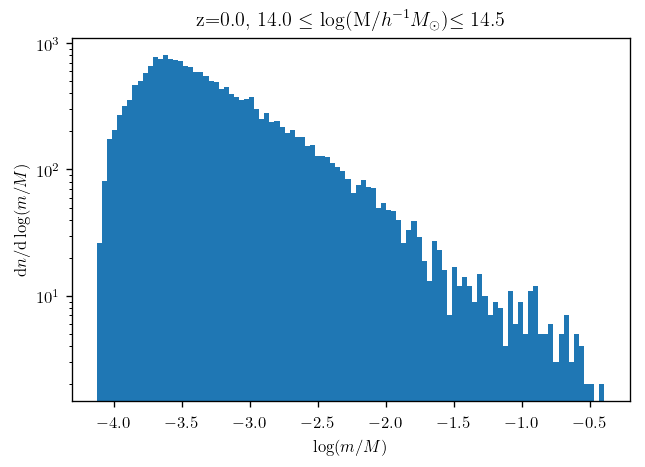

In [28]:
def SHMF_M1M2(M1, M2, step, bins=100):
    plot_arr = np.array([])

    # parent halo mass
    for fofhalotag, M in zip(mt['fof_halo_tag'], mt['fof_halo_mass']):
        if M1 <= M <= M2:
            # array of subhalo masses for this parent halo with central subhalos (subhalo tag == 0) removed 
            m_arr = sh['subhalo_mass'][ (sh['fof_halo_tag'] == fofhalotag) & (sh['subhalo_tag']>0) ]
            plot_arr = np.hstack( (plot_arr, m_arr/M) )
    
    plt.figure(dpi=120)
    plt.hist(np.log10(plot_arr), bins=bins, histtype='bar', density=False)
    plt.yscale('log')
    
    plt.xlabel(r'$\log(m/M)$')
    plt.ylabel(r'$\mathrm{d}n/\mathrm{d} \log(m/M)$')
    plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) )
    
    return plot_arr

sh_plotarr = SHMF_M1M2(M1,M2,step)

In [20]:
# Load extended core catalog
cc = read_dict_from_disk(outfile)

satellites_mask = cc['central'] == 0
centrals_mask = cc['central'] == 1

# Match satellites tni with centrals tni.
vals2, idx3, idx4 = np.intersect1d( cc['tree_node_index'][satellites_mask], cc['tree_node_index'][centrals_mask], return_indices=True)

# Unique satellites tni array with inverse indices
vals3, idx_inv = np.unique(cc['tree_node_index'][satellites_mask], return_inverse=True)

# Some checks
assert np.array_equal(vals2, vals3), "All satellites don't have a central match."
assert np.array_equal(vals3[idx_inv], cc['tree_node_index'][satellites_mask]), 'np.unique inverse indices: original array recreation failure'
assert np.array_equal(cc['tree_node_index'][centrals_mask][idx4], np.sort(cc['tree_node_index'][centrals_mask][idx4])), 'Centrals with satellites: array sorting failure'

# Create M array (corresponds with cc[satellites_mask]) to be host tree node mass of each satellite
M = cc['infall_mass'][centrals_mask][idx4][idx_inv]

# m/M array for SHMF
plot_arr = cc['m_evolved'][satellites_mask]/M

# M1 <= M <= M2 mask and infall mass >= 100 Particles mask
plot_arr = plot_arr[ (M1 <= M) & (M <= M2) & (cc['infall_mass'][satellites_mask] >= SHMLM.PARTICLES100MASS) ]

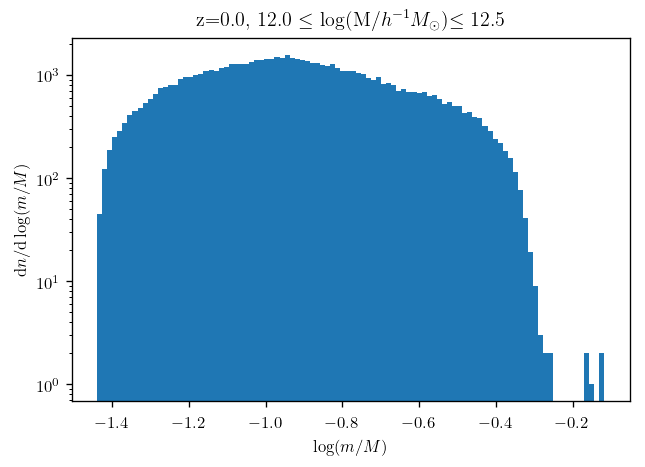

In [21]:
unevolved_plotarr = cc['infall_mass'][satellites_mask]/M
# M1 <= M <= M2 mask and infall mass >= 100 Particles mask
unevolved_plotarr = unevolved_plotarr[ (M1 <= M) & (M <= M2) & (cc['infall_mass'][satellites_mask] >= SHMLM.PARTICLES100MASS) ]

plt.figure(dpi=120)
n, bins_plt, _ = plt.hist(np.log10(unevolved_plotarr), bins=100)
plt.yscale('log')

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\mathrm{d}n/\mathrm{d} \log(m/M)$')
plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );

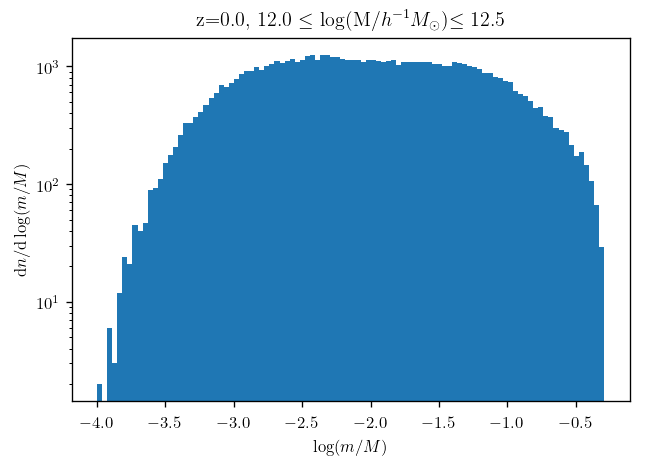

In [22]:
plt.figure(dpi=120)
n, bins_plt, _ = plt.hist(np.log10(plot_arr), bins=100)
plt.yscale('log')

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\mathrm{d}n/\mathrm{d} \log(m/M)$')
plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );

In [23]:
nHalo = np.unique(cc['tree_node_index'][satellites_mask][ (M1 <= M) & (M <= M2) & (cc['infall_mass'][satellites_mask] >= SHMLM.PARTICLES100MASS) ]).size
nHalo

32680

In [24]:
assert np.unique(mt['fof_halo_tag']).shape == mt['fof_halo_tag'].shape
nHalo_mt = mt['fof_halo_tag'][(M1 <= mt['fof_halo_mass']) & (mt['fof_halo_mass'] <= M2)].shape[0]
print nHalo_mt

37181


/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


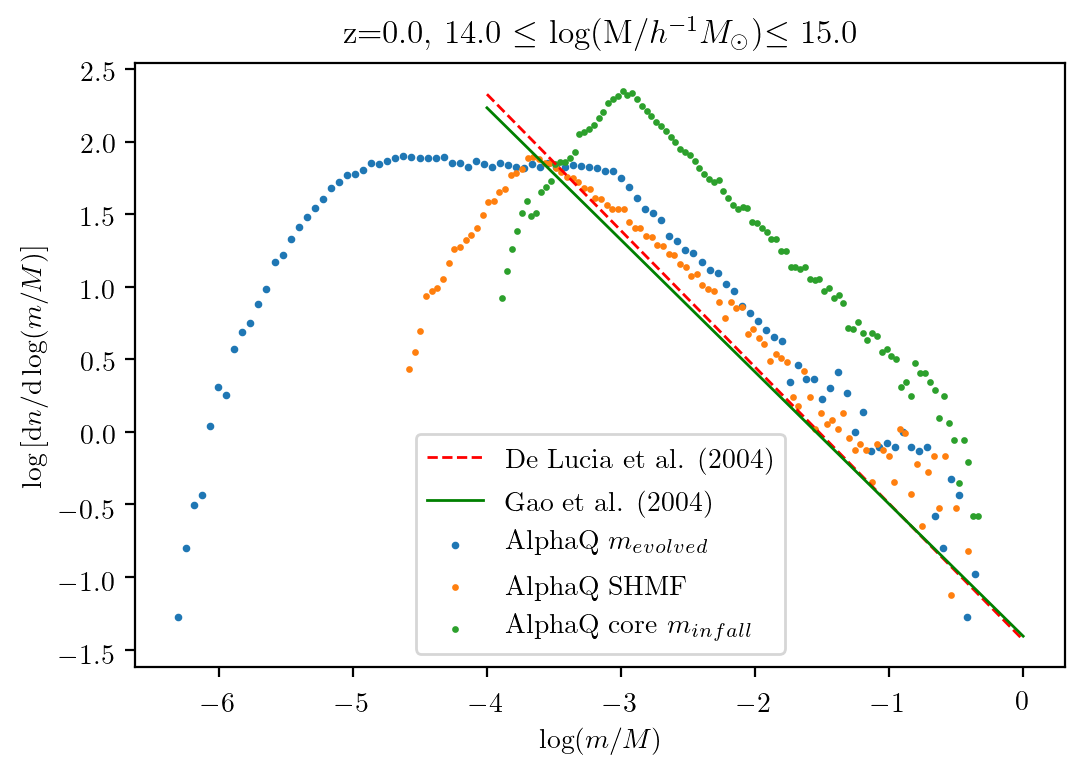

In [13]:
plt.figure(dpi=200)
counts, bin_edges = np.histogram(np.log10(plot_arr), bins=100)
x_arr = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
bs1 = (bin_edges[1] - bin_edges[0])
plt.scatter(x_arr, np.log10(counts/bs1/nHalo), s=3, label=r'AlphaQ $m_{evolved}$' )

c2, b2 = np.histogram(np.log10(sh_plotarr), bins=100)
x_arr3 = b2[:-1] + (b2[1] - b2[0])/2
binsize = (b2[1] - b2[0])
plt.scatter(x_arr3, np.log10(c2/binsize/nHalo), s=2, label='AlphaQ SHMF' )

c3, b3 = np.histogram(np.log10(unevolved_plotarr), bins=100)
x_arr4 = b3[:-1] + (b3[1] - b3[0])/2
bs2 = (b3[1] - b3[0])
plt.scatter(x_arr4, np.log10(c3/bs2/nHalo), s=2, label='AlphaQ core $m_{infall}$' )

x_arr2 = np.linspace(-4, 0)
plt.plot(x_arr2, np.poly1d([-0.94 ,  np.log10(0.016/np.log10(np.e))])(x_arr2), '--', c='r', linewidth=1, label='De Lucia et al. (2004)')
plt.plot(x_arr2, np.poly1d([-0.91 ,  np.log10(0.017/np.log10(np.e))])(x_arr2), c='g', linewidth=1, label='Gao et al. (2004)')

# plt.yscale('log')

# plt.axvline(x=-3, c='k', linewidth=.2)
# plt.axvline(x=-2, c='k', linewidth=.2)

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );
plt.legend();

De Lucia et al. (2004): 
$$\frac{\mathrm{d}n}{\mathrm{d}\ln(m/M)} = 0.016 \left(\frac{m}{M}\right)^{-0.94}$$

Gao et al. (2004): 
$$\frac{\mathrm{d}n}{\mathrm{d}\ln(m/M)} = 0.017 \left(\frac{m}{M}\right)^{-0.91}$$

AlphaQ SHMF fitting ($-3 \lt \log (m/M) \lt -2$) wrong: 
$$\frac{\mathrm{d}n}{\mathrm{d}\ln(m/M)} = 0.680 \left(\frac{m}{M}\right)^{-0.813}$$

AlphaQ Unevolved SHMF fitting ($-3 \lt \log (m/M) \lt -2$) wrong: 
$$\frac{\mathrm{d}n}{\mathrm{d}\ln(m/M)} = 1.60 \left(\frac{m}{M}\right)^{-0.962}$$

In [58]:
np.polyfit(x_arr3[(-3 < x_arr3)&(x_arr3 < -2)], np.log10(c2[(-3 < x_arr3)&(x_arr3 < -2)]), deg=1)

array([-0.81525402,  0.19495605])

In [60]:
np.polyfit(x_arr4[(-3 < x_arr4)&(x_arr4 < -2)], np.log10(c3[(-3 < x_arr4)&(x_arr4 < -2)]), deg=1)

array([-0.96172221,  0.56512888])

In [61]:
10**0.56512888 * np.log10(np.e)

1.5955601877418424

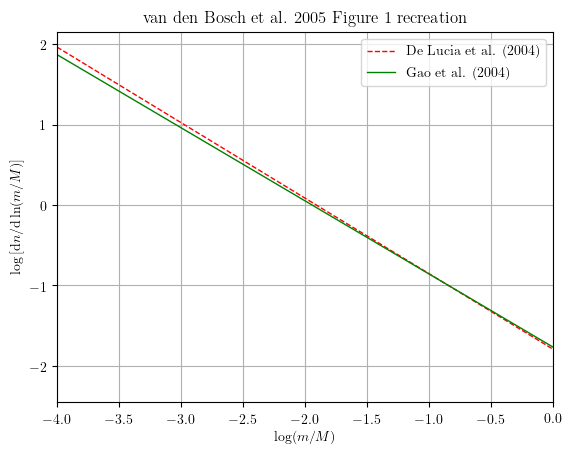

In [134]:
plt.figure(dpi=100)
x_arr5 = np.linspace(-4, 0)
plt.plot(x_arr5, np.poly1d([-0.94 ,  np.log10(0.016)])(x_arr5), '--', c='r', linewidth=1, label='De Lucia et al. (2004)')
plt.plot(x_arr5, np.poly1d([-0.91 ,  np.log10(0.017)])(x_arr5), c='g', linewidth=1, label='Gao et al. (2004)')

plt.xlim(-4,0)
plt.ylim(-2.45,2.15)

ax = plt.axes()
ax.grid();
# ax.set_aspect('equal')

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \ln(m/M) \right]$')
plt.title( 'van den Bosch et al. 2005 Figure 1 recreation' );
plt.legend();

/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


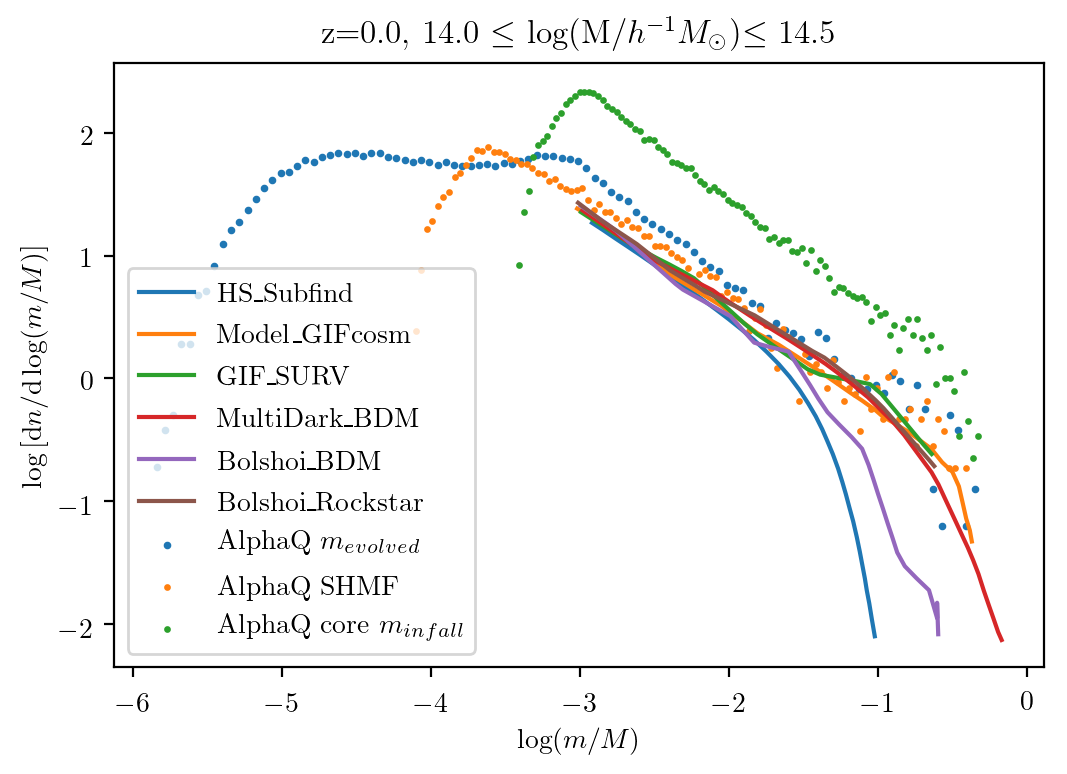

In [13]:
f = '2016b_fig5c.csv'

HS_Subfind = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(0,1), max_rows=36)
GIF_SURV = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(2,3), max_rows=30)
Bolshoi_BDM = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(4,5), max_rows=30)
Bolshoi_Rockstar = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(6,7), max_rows=18)
MultiDark_BDM = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(8,9), max_rows=35)
Model_GIFcosm = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(10,11), max_rows=22)

plotsd = {'HS\_Subfind': HS_Subfind, 'GIF\_SURV':GIF_SURV, 'Bolshoi\_BDM':Bolshoi_BDM, 'Bolshoi\_Rockstar':Bolshoi_Rockstar, 'MultiDark\_BDM':MultiDark_BDM, 'Model\_GIFcosm':Model_GIFcosm}

plt.figure(dpi=200)

for k in plotsd.keys():
    plt.plot(plotsd[k][:,0][np.argsort(plotsd[k][:,0])], plotsd[k][:,1][np.argsort(plotsd[k][:,0])], '-', label=k)
    
counts, bin_edges = np.histogram(np.log10(plot_arr), bins=100)
x_arr = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
bs1 = (bin_edges[1] - bin_edges[0])
plt.scatter(x_arr, np.log10(counts/bs1/nHalo), s=3, label=r'AlphaQ $m_{evolved}$' )

c2, b2 = np.histogram(np.log10(sh_plotarr), bins=100)
x_arr3 = b2[:-1] + (b2[1] - b2[0])/2
binsize = (b2[1] - b2[0])
plt.scatter(x_arr3, np.log10(c2/binsize/nHalo), s=2, label='AlphaQ SHMF' )

c3, b3 = np.histogram(np.log10(unevolved_plotarr), bins=100)
x_arr4 = b3[:-1] + (b3[1] - b3[0])/2
bs2 = (b3[1] - b3[0])
plt.scatter(x_arr4, np.log10(c3/bs2/nHalo), s=2, label='AlphaQ core $m_{infall}$' )

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );
plt.legend();

/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


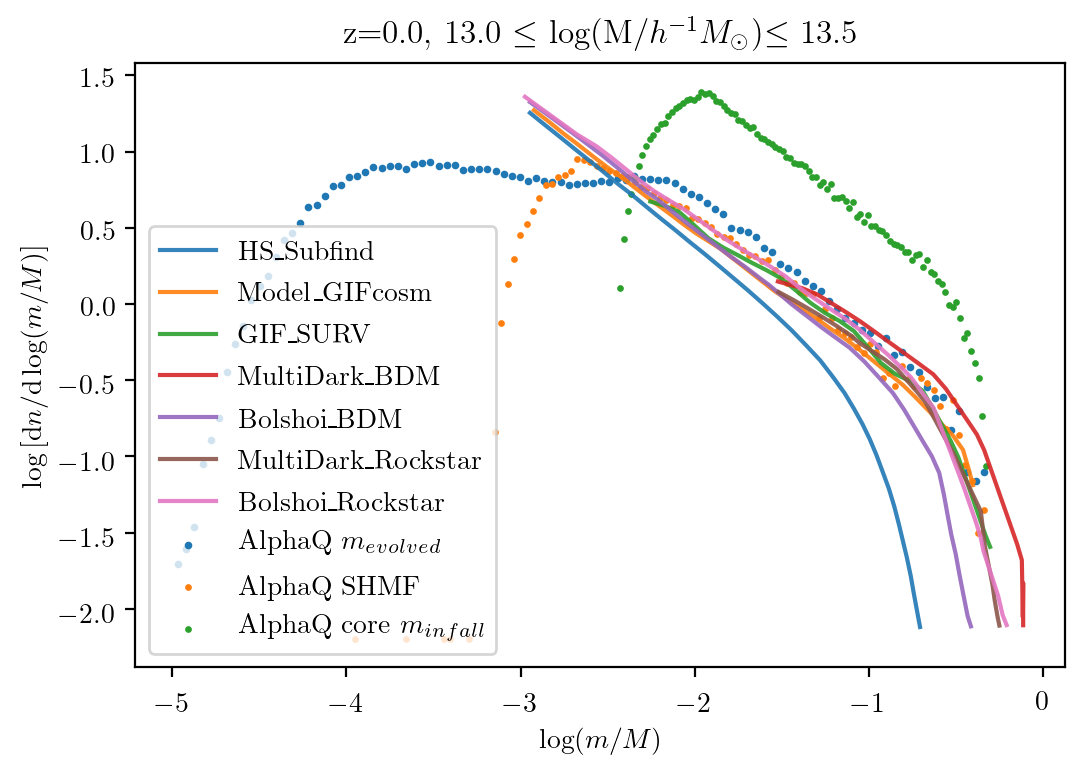

In [13]:
f = '2016b_fig5b.csv'

HS_Subfind = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(0,1), max_rows=37)
Bolshoi_BDM = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(2,3), max_rows=38)[:-1]
GIF_SURV = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(4,5), max_rows=30)
Model_GIFcosm = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(6,7), max_rows=25)
Bolshoi_Rockstar = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(8,9), max_rows=36)
MultiDark_BDM = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(10,11), max_rows=26)
MultiDark_Rockstar  = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(12,13), max_rows=18)

plotsd = {'HS\_Subfind': HS_Subfind, 'GIF\_SURV':GIF_SURV, 'Bolshoi\_BDM':Bolshoi_BDM, 'Bolshoi\_Rockstar':Bolshoi_Rockstar, 'MultiDark\_BDM':MultiDark_BDM, 'Model\_GIFcosm':Model_GIFcosm, 'MultiDark\_Rockstar':MultiDark_Rockstar}

plt.figure(dpi=200)

for k in plotsd.keys():
    plt.plot(plotsd[k][:,0][np.argsort(plotsd[k][:,0])], plotsd[k][:,1][np.argsort(plotsd[k][:,0])], '-', label=k, alpha=0.9)
    
counts, bin_edges = np.histogram(np.log10(plot_arr), bins=100)
x_arr = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
bs1 = (bin_edges[1] - bin_edges[0])
plt.scatter(x_arr, np.log10(counts/bs1/nHalo), s=3, label=r'AlphaQ $m_{evolved}$' )

c2, b2 = np.histogram(np.log10(sh_plotarr), bins=100)
x_arr3 = b2[:-1] + (b2[1] - b2[0])/2
binsize = (b2[1] - b2[0])
plt.scatter(x_arr3, np.log10(c2/binsize/nHalo), s=2, label='AlphaQ SHMF' )

c3, b3 = np.histogram(np.log10(unevolved_plotarr), bins=100)
x_arr4 = b3[:-1] + (b3[1] - b3[0])/2
bs2 = (b3[1] - b3[0])
plt.scatter(x_arr4, np.log10(c3/bs2/nHalo), s=2, label='AlphaQ core $m_{infall}$' )

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );
plt.legend();



/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


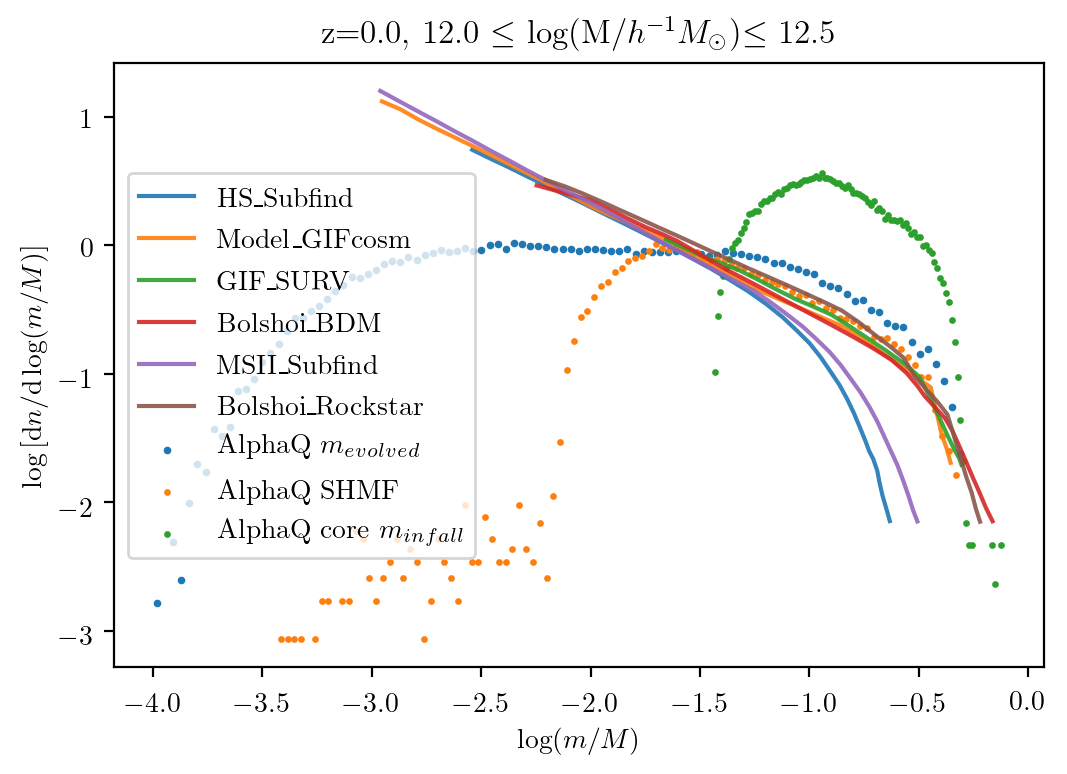

In [25]:
f = '2016b_fig5a.csv'

HS_Subfind = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(0,1), max_rows=34)
Model_GIFcosm = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(2,3), max_rows=18)
Bolshoi_Rockstar = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(4,5), max_rows=28)
MSII_Subfind = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(6,7), max_rows=34)
Bolshoi_BDM = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(8,9), max_rows=29)[:-1]
GIF_SURV = np.loadtxt(f, delimiter=',', skiprows=2, usecols=(10,11), max_rows=22)

plotsd = {'HS\_Subfind': HS_Subfind, 'GIF\_SURV':GIF_SURV, 'Bolshoi\_BDM':Bolshoi_BDM, 'Bolshoi\_Rockstar':Bolshoi_Rockstar, 'Model\_GIFcosm':Model_GIFcosm, 'MSII\_Subfind':MSII_Subfind, }

plt.figure(dpi=200)

for k in plotsd.keys():
    plt.plot(plotsd[k][:,0][np.argsort(plotsd[k][:,0])], plotsd[k][:,1][np.argsort(plotsd[k][:,0])], '-', label=k, alpha=0.9)
    
counts, bin_edges = np.histogram(np.log10(plot_arr), bins=100)
x_arr = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
bs1 = (bin_edges[1] - bin_edges[0])
plt.scatter(x_arr, np.log10(counts/bs1/nHalo), s=3, label=r'AlphaQ $m_{evolved}$' )

c2, b2 = np.histogram(np.log10(sh_plotarr), bins=100)
x_arr3 = b2[:-1] + (b2[1] - b2[0])/2
binsize = (b2[1] - b2[0])
plt.scatter(x_arr3, np.log10(c2/binsize/nHalo_mt), s=2, label='AlphaQ SHMF' )

c3, b3 = np.histogram(np.log10(unevolved_plotarr), bins=100)
x_arr4 = b3[:-1] + (b3[1] - b3[0])/2
bs2 = (b3[1] - b3[0])
plt.scatter(x_arr4, np.log10(c3/bs2/nHalo), s=2, label='AlphaQ core $m_{infall}$' )

plt.xlabel(r'$\log(m/M)$')
plt.ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
plt.title( 'z=' + str(round(SHMLM.step2z[step],3)) + r', {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) );
plt.legend();

